In [720]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from scipy.io import loadmat
from scipy.optimize import fmin_cg

# Exercise 8.1: Anomaly Detection (dimension-2)
---

In this first part of exercise-8, we calculate multivariate Gaussian distributions based on the spread of the data, then determine a decision boundary for what is regarded as "normal" (close to the peak of the distribution) and what is regarded as "anomalous" (far from the peak of the distribution). This decision boundary is found via some cross-validation data set, on which we have "normal" and "anomalous" labels, and we try a range of boundaries and choose that which maximises the F1 score for the cross-validation data. First we do a 2D problem, then an 11D problem with the exact same techniques. Begin by checking out the 2D data:

In [727]:
d1 = loadmat('ex8/ex8data1.mat')
d1.keys()
# dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [728]:
d1_X = d1['X']
d1_X.shape
# (307, 2)

(307, 2)

In [729]:
d1_Xval = d1['Xval']
d1_Xval.shape
# (307, 2)

(307, 2)

In [730]:
d1_yval = d1['yval']
d1_yval.shape
# (307, 1)

(307, 1)

In [731]:
del(d1)

In [467]:
d1_yval_idx_0 = np.where(d1_yval == 0) # "normal"
d1_yval_idx_1 = np.where(d1_yval == 1) # "anomalous"

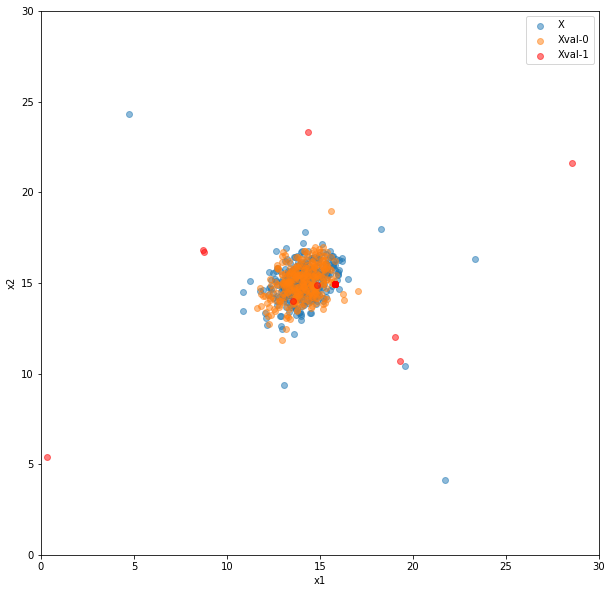

In [523]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.scatter(d1_X[:,0], d1['X'][:,1], color='C0', alpha=0.5)
ax.scatter(d1_Xval[d1_yval_idx_0,0], d1_Xval[d1_yval_idx_0,1], color='C1', alpha=0.5)
ax.scatter(d1_Xval[d1_yval_idx_1,0], d1_Xval[d1_yval_idx_1,1], color='r', alpha=0.5)
ax.set_xlim(0.0, 30.0)
ax.set_ylim(0.0, 30.0)
ax.set(xlabel='x1', ylabel='x2')
ax.legend(['X', 'Xval-0', 'Xval-1'])
plt.show()

---

Get means and standard deviations for the main data in all dimensions:

In [34]:
def get_mu_sigma(
    X,
):

    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
#     sigma = np.sqrt((1 / X.shape[0]) * np.sum(np.power((X - mu),2), axis=0)) # n.b. This gives the same standard deviation values as np.std, just checking

    return(mu, sigma)

In [470]:
d1_X_mu, d1_X_sigma = get_mu_sigma(d1_X)
print(d1_X_mu)
print(d1_X_sigma)
# [14.11222578 14.99771051]
# [1.35374717 1.3075723 ]

[14.11222578 14.99771051]
[1.35374717 1.3075723 ]


---

Get the multivariate Gaussian value for each given data point. Note that the commented version does seem to give the same output as the live version, but the former is my own version (just from multiplying together univariate Gaussians in the most straightforward way), and the latter is a more "proper" version for linear algebra, at least according to some literature I found (e.g. http://cs229.stanford.edu/section/gaussians.pdf). Andrew also uses the latter in his Octave version:

In [171]:
def get_gaussian(
    X,
    mu,
    sigma,
):

#     gaussian = \
#           np.power((1 / np.sqrt(2 * np.pi)), X.shape[1]) \
#         * (1 / np.product(sigma)) \
#         * np.exp((-1 / 2) * np.sum(np.power(((X - mu) / sigma), 2), axis=1))
#     return(gaussian)

    X_minus_mu = X - mu

    gaussian = \
          np.power((1 / np.sqrt(2 * np.pi)), X.shape[1]) \
        * (1 / np.linalg.det(np.diag(sigma))) \
        * np.exp((-1 / 2) * np.sum(np.dot(X_minus_mu, np.linalg.pinv(np.diag(np.power(sigma,2)))) * X_minus_mu, axis=1))

    return(gaussian)

Let's have a look at the Gaussian contours for the main data parameters:

In [442]:
d1_x1_range = max(d1_X[:,0]) - min(d1_X[:,0])
d1_x1_lower = min(d1_X[:,0]) - (d1_x1_range * 0.2)
d1_x1_upper = max(d1_X[:,0]) + (d1_x1_range * 0.2)

d1_x2_range = max(d1_X[:,1]) - min(d1_X[:,1])
d1_x2_lower = min(d1_X[:,1]) - (d1_x2_range * 0.2)
d1_x2_upper = max(d1_X[:,1]) + (d1_x2_range * 0.2)

d1_x1s = np.linspace(d1_x1_lower, d1_x1_upper, 100)
d1_x2s = np.linspace(d1_x2_lower, d1_x2_upper, 100)

# n.b. Not intuitive, but these are given in terms of [x2,x1], not [x1,x2], hence the following transpose to get them as [x1,x2], just because that's more intuitive for me:
d1_x1s_meshgrid, d1_x2s_meshgrid = np.meshgrid(d1_x1s, d1_x2s)

d1_x1s_meshgrid = np.transpose(d1_x1s_meshgrid)
d1_x2s_meshgrid = np.transpose(d1_x2s_meshgrid)

print(d1_x1s_meshgrid.shape)
print(d1_x2s_meshgrid.shape)
# (100, 100)
# (100, 100)

(100, 100)
(100, 100)


In [443]:
d1_X_meshgrid_reshape = np.array(np.transpose([
    d1_x1s_meshgrid.reshape(len(d1_x1s) * len(d1_x2s)),
    d1_x2s_meshgrid.reshape(len(d1_x1s) * len(d1_x2s)),
]))
d1_X_meshgrid_reshape.shape
# (10000, 2)

(10000, 2)

In [471]:
d1_X_meshgrid_reshape_gaussian = get_gaussian(d1_X_meshgrid_reshape, d1_X_mu, d1_X_sigma)
d1_X_meshgrid_reshape_gaussian.shape
# (10000,)

(10000,)

In [445]:
d1_X_meshgrid_gaussian = d1_X_meshgrid_reshape_gaussian.reshape([len(d1_x1s), len(d1_x2s)])
d1_X_meshgrid_gaussian.shape
# (100, 100)

(100, 100)

In [446]:
print(np.min(d1_X_meshgrid_gaussian))
print(np.max(d1_X_meshgrid_gaussian))
# 2.7084210483238043e-50
# 0.08975509942590283

2.7084210483238043e-50
0.08975509942590283


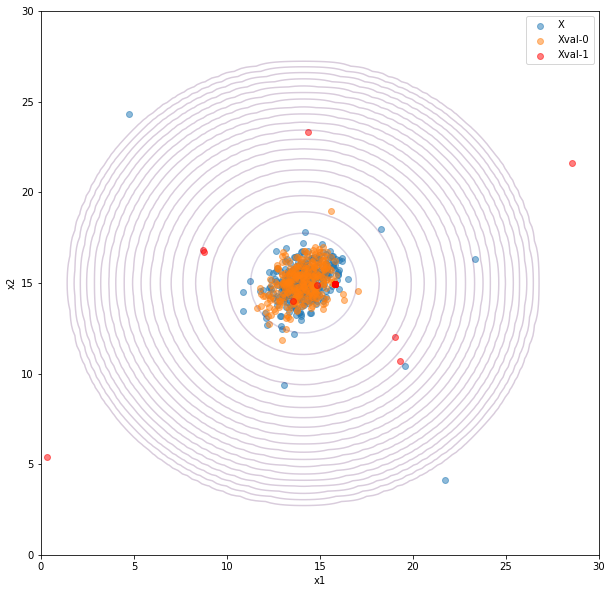

In [524]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.scatter(d1_X[:,0], d1_X[:,1], color='C0', alpha=0.5)
ax.scatter(d1_Xval[d1_yval_idx_0,0], d1_Xval[d1_yval_idx_0,1], color='C1', alpha=0.5)
ax.scatter(d1_Xval[d1_yval_idx_1,0], d1_Xval[d1_yval_idx_1,1], color='r', alpha=0.5)
ax.contour(d1_x1s, d1_x2s, np.transpose(d1_X_meshgrid_gaussian), levels=sorted(10.0**(-(np.arange(20)+1))), alpha=0.2)
ax.set_xlim(0.0, 30.0)
ax.set_ylim(0.0, 30.0)
ax.set(xlabel='x1', ylabel='x2')
ax.legend(['X', 'Xval-0', 'Xval-1'])
plt.show()

---

Now run a range of threshold Gaussian values, and see which provides the best contour for separating "normal" and "anomalous" cross-validation examples, judged in terms of the F1 score that each threshold provides. Note that the Gaussian values for the cross-validation data are in terms of the parameters found for the unlabelled main data, for which we are really seeking a decision boundary:

In [479]:
def get_threshold(
    Xval_gaussian,
    yval,
):

    yval_anomalous_num = sum(yval) # Equivalent to true-pos + false-neg
    thresholds = np.arange(0,1001) * ((max(Xval_gaussian) - min(Xval_gaussian)) / 1000) + min(Xval_gaussian)
    F1s = []

    for threshold in thresholds:
        yval_anomalous_predicted = yval[np.where(Xval_gaussian <= threshold)]
        yval_anomalous_predicted_num = len(yval_anomalous_predicted) # Equivalent to true-pos + false-pos
        yval_anomalous_predicted_truepos_num = sum(yval_anomalous_predicted)
        p = yval_anomalous_predicted_truepos_num / yval_anomalous_predicted_num
        r = yval_anomalous_predicted_truepos_num / yval_anomalous_num
        F1 = (2 * p * r) / (p + r)
        F1s.append(F1)

    thresholds_idx_chosen = np.argmax(F1s)

    threshold_chosen = thresholds[thresholds_idx_chosen]
    F1_chosen = F1s[thresholds_idx_chosen]

    return(threshold_chosen, F1_chosen)

In [480]:
d1_Xval_gaussian = get_gaussian(d1_Xval, d1_X_mu, d1_X_sigma)
d1_Xval_gaussian.shape
# (307,)

(307,)

In [481]:
d1_threshold, d1_F1 = get_threshold(d1_Xval_gaussian, d1_yval)
print(d1_threshold)
print(d1_F1)
# 8.990852779269493e-05
# [0.875]

8.990852779269493e-05
[0.875]


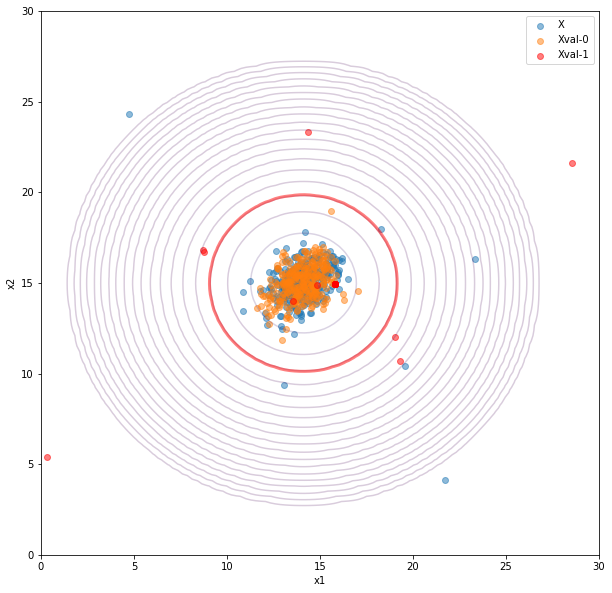

In [525]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.scatter(d1_X[:,0], d1_X[:,1], color='C0', alpha=0.5)
ax.scatter(d1_Xval[d1_yval_idx_0,0], d1_Xval[d1_yval_idx_0,1], color='C1', alpha=0.5)
ax.scatter(d1_Xval[d1_yval_idx_1,0], d1_Xval[d1_yval_idx_1,1], color='r', alpha=0.5)
ax.contour(d1_x1s, d1_x2s, np.transpose(d1_X_meshgrid_gaussian), levels=sorted(10.0**(-(np.arange(20)+1))), alpha=0.2)
ax.contour(d1_x1s, d1_x2s, np.transpose(d1_X_meshgrid_gaussian), levels=[d1_threshold], colors=['r'], linewidths=[3], alpha=0.5)
ax.set_xlim(0.0, 30.0)
ax.set_ylim(0.0, 30.0)
ax.set(xlabel='x1', ylabel='x2')
ax.legend(['X', 'Xval-0', 'Xval-1'])
plt.show()

---

Using the decision boundary determined from the cross-validation data, highlight which of the main data points would then be regarded as "anomalous":

In [285]:
d1_X_gaussian = get_gaussian(d1_X, d1_X_mu, d1_X_sigma)
d1_X_gaussian.shape
# (307,)

(307,)

In [522]:
d1_X_idx_anomalous = np.where(d1_X_gaussian <= d1_threshold)
len(d1_X_idx_anomalous[0])
# 6

6

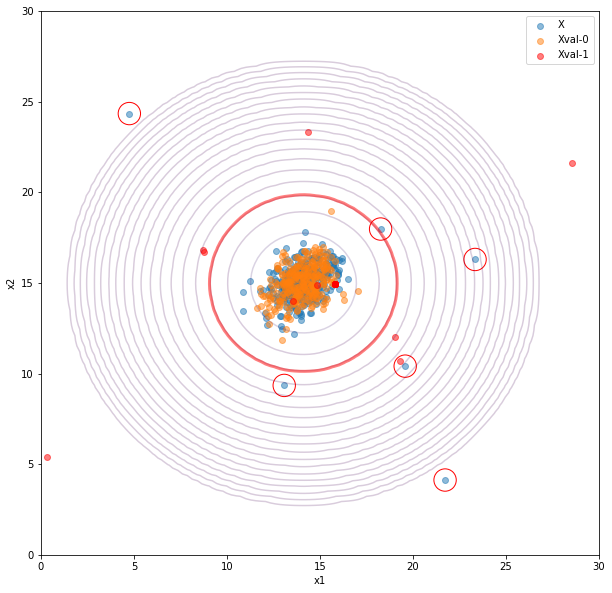

In [526]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.scatter(d1_X[:,0], d1_X[:,1], color='C0', alpha=0.5)
ax.scatter(d1_Xval[d1_yval_idx_0,0], d1_Xval[d1_yval_idx_0,1], color='C1', alpha=0.5)
ax.scatter(d1_Xval[d1_yval_idx_1,0], d1_Xval[d1_yval_idx_1,1], color='r', alpha=0.5)
ax.scatter(d1_X[d1_X_idx_anomalous,0], d1_X[d1_X_idx_anomalous,1], facecolor='none', edgecolor='r', s=500)
ax.contour(d1_x1s, d1_x2s, np.transpose(d1_X_meshgrid_gaussian), levels=sorted(10.0**(-(np.arange(20)+1))), alpha=0.2)
ax.contour(d1_x1s, d1_x2s, np.transpose(d1_X_meshgrid_gaussian), levels=[d1_threshold], colors=['r'], linewidths=[3], alpha=0.5)
ax.set_xlim(0.0, 30.0)
ax.set_ylim(0.0, 30.0)
ax.set(xlabel='x1', ylabel='x2')
ax.legend(['X', 'Xval-0', 'Xval-1'])
plt.show()

# Exercise 8.1: Anomaly Detection (dimension-11)
---

Just to show the generality of the above approach, we now repeat the exact same steps here with 11D data:

In [732]:
d2 = loadmat('ex8/ex8data2.mat')
d2.keys()
# dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Xval', 'yval'])

In [733]:
d2_X = d2['X']
d2_X.shape
# (1000, 11)

(1000, 11)

In [734]:
d2_Xval = d2['Xval']
d2_Xval.shape
# (100, 11)

(100, 11)

In [735]:
d2_yval = d2['yval']
d2_yval.shape
# (100, 1)

(100, 1)

In [736]:
del(d2)

In [532]:
d2_X_mu, d2_X_sigma = get_mu_sigma(d2_X)
print(d2_X_mu)
print(d2_X_sigma)
# [  4.93940034  -9.63726819  13.81470749 -10.4644888   -7.95622922
#   10.19950372  -6.01940755   7.96982896  -6.2531819    2.32451289
#    8.47372252]
# [7.80864225 7.29422524 7.64954003 9.17627578 8.07889793 9.46440054
#  7.4587867  9.33607722 5.44327735 8.41339439 7.10658618]

[  4.93940034  -9.63726819  13.81470749 -10.4644888   -7.95622922
  10.19950372  -6.01940755   7.96982896  -6.2531819    2.32451289
   8.47372252]
[7.80864225 7.29422524 7.64954003 9.17627578 8.07889793 9.46440054
 7.4587867  9.33607722 5.44327735 8.41339439 7.10658618]


In [533]:
d2_Xval_gaussian = get_gaussian(d2_Xval, d2_X_mu, d2_X_sigma)
d2_Xval_gaussian.shape
# (100,)

(100,)

In [534]:
d2_threshold, d2_F1 = get_threshold(d2_Xval_gaussian, d2_yval)
print(d2_threshold)
print(d2_F1)
# 1.3772288907613583e-18
# [0.61538462]

1.3772288907613583e-18
[0.61538462]


In [321]:
d2_X_gaussian = get_gaussian(d2_X, d2_X_mu, d2_X_sigma)
d2_X_gaussian.shape
# (1000,)

(1000,)

In [535]:
d2_X_idx_anomalous = np.where(d2_X_gaussian <= d2_threshold)
len(d2_X_idx_anomalous[0])
# 117

117

# Exercise 8.2: Recommender Systems (Collaborative Filtering)
---

Now for something completely different, in no apparent way related to any of the above. In all other exercises we seek one parameter or set of parameters to match some given data. Here, though, we seek two sets of parameters, adjusting them both to match each other. In the guise of a movie recommender system, the idea is that each movie has a certain set of features, and each user has a certain set of features, both sets of features being matched in number, and the two work together to give the data that we see, which is a set of movie reviews. In essence, the movies give certain output channels that are received by the users' input channels, and different people get affected differently by different combinations of channels being activated. With two sets of parameters to optimise, the required computations are increased by at least an order of magnitude (just my own guess), as we must somehow scan all of movie-feature-space for every location in user-feature-space, with the cost function determined by how well we are matching the given set of reviews overall, for all movies and all users.

First let's check out the review data, which are given as one array ("Y") of 1682 movies $\times$ 943 users with review scores of 1 to 5, and a separate array ("R") of matching dimensionality that just says whether or not a review has been given for a particular movie by a particular user (which is a bit superfluous, as the same information can be given from where "Y" is 0):

In [742]:
d3 = loadmat('ex8/ex8_movies.mat')
d3.keys()
# dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])

dict_keys(['__header__', '__version__', '__globals__', 'Y', 'R'])

In [743]:
d3_Y = d3['Y']
d3_Y.shape
# (1682, 943)

(1682, 943)

In [744]:
d3_R = d3['R']
d3_R.shape
# (1682, 943)

(1682, 943)

In [745]:
del(d3)

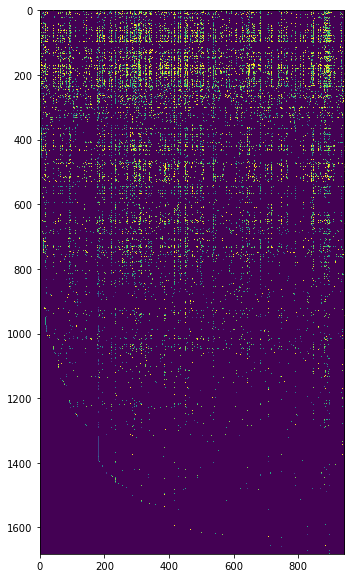

In [746]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.imshow(d3_Y)
plt.show()

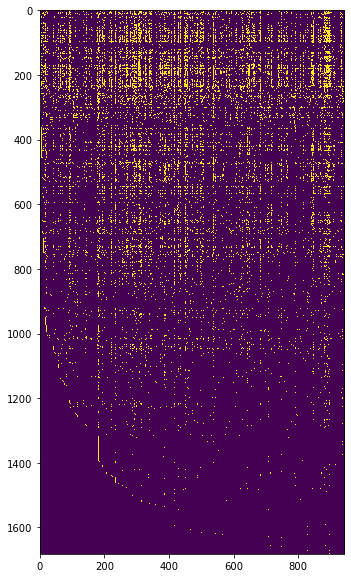

In [747]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.imshow(d3_R)
plt.show()

---

Let's see what the mean score is for a certain movie (the first movie in the list was "Toy Story"), making sure we only use the non-zero scores i.e. the actually submitted review scores:

In [748]:
np.mean(d3_Y[0, np.where(d3_R[0,:] == 1)])
# 3.8783185840707963

3.8783185840707963

---

First thing to note here is that the cost function is a least-mean-squares type, meaning that we are fitting some hypersurface to actually fit the data itself, rather than to separate the data, for which we use sigmoid-based hypothesis functions and log-based cost functions in other exercises. Even though the derivatives can also be given from the following cost function, later on we use the ``fmin_cg`` optimisation function with no explicit derivative input, meaning that the derivatives in the following cost function (which may or may not be entirely correct!) are superfluous, as the ``fmin_cg`` function calculates its own. I think the derivate declarations used below should be fine, or are at least in accordance with Andrew's notes, but it took a while for me to visualise exactly what was going on. I now have the interpretation that:

- ``dcost_by_dX`` = How much the movie features should be adjusted i.e. each feature over all users (from ``theta``) summed in a weighted fashion according to how correct the current prediction is (``h_minus_Y``), and not involved in the sum if the user hasn't seen the movie (from ``h_minus_Y[R_idx_0] = 0``)
- ``dcost_by_dtheta`` = How much the user features should be adjusted i.e. each feature over all movies (from ``X``) summed in a weighted fashion according to how correct the current prediction is (``h_minus_Y``), and not involved in the sum if the user hasn't seen the movie (from ``h_minus_Y[R_idx_0] = 0``)

In order to re-visualise, consider the just first column of the second matrix (the first feature for either users or movies) in the dot-product for a particular derivative, and imagine it collapsing with just the first row of the first matrix (the first movie or user depending on orientation). The first matrix is the indication of correctness we currently have, and weights the summation of the feature over the dimension being summed out, in order to give an amount by which that feature should be adjusted for that movie/user. Same process for the same feature vector with all the other rows of the first matrix, then same process for all other feature vectors with all rows of the first matrix. Hopefully this will still make sense on re-reading.

In [764]:
# This function is reduced via the comments in order to run more efficiently with fmin_cg, but the commented lines should hopefully be fine if used

def get_cost(
    X_theta,
    X_num,
    movies_num,
    users_num,
    features_num,
    lamb,
#     R_idx_0,
    R_idx_1,
    Y,
    get_derivative=True,
):

    X = X_theta[:X_num].reshape([movies_num, features_num])
    theta = X_theta[X_num:].reshape([users_num, features_num])

    h = np.dot(X, np.transpose(theta))
    h_minus_Y = h
#     h_minus_Y[R_idx_0] = 0 # Set to zero in order to provide zero weight in the derivative dot-products for these movie-user combinations
    h_minus_Y[R_idx_1] -= Y[R_idx_1]

    cost = \
          0.5 * np.sum(np.power(h_minus_Y[R_idx_1], 2)) \
        + (lamb / 2) * (np.sum(np.power(X, 2)) + np.sum(np.power(theta, 2)))

    if (not get_derivative):
        return(cost)
    else:
        dcost_by_dX = np.dot(h_minus_Y, theta) + (lamb * X)
        dcost_by_dtheta = np.dot(np.transpose(h_minus_Y), X) + (lamb * theta)
        return(cost, dcost_by_dX, dcost_by_dtheta)

In [766]:
def get_X_theta(
    X_theta_init,
    X_num,
    movies_num,
    users_num,
    features_num,
    lamb,
    iters_num,
#     R_idx_0,
    R_idx_1,
    Y,
    disp=True,
):

    X_theta = fmin_cg(
        get_cost,
        X_theta_init,
        args = (
            X_num,
            movies_num,
            users_num,
            features_num,
            lamb,
#             R_idx_0,
            R_idx_1,
            Y,
            False,
        ),
        maxiter=iters_num,
        disp=disp,
    )

    return(X_theta)

---

Test the cost function with some predetermined parameters ``X`` and ``theta``, using a reduced number of movies and users:

In [753]:
params = loadmat('ex8/ex8_movieParams.mat')
params.keys()
# dict_keys(['__header__', '__version__', '__globals__', 'X', 'Theta', 'num_users', 'num_movies', 'num_features'])

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Theta', 'num_users', 'num_movies', 'num_features'])

In [754]:
params['X'].shape
# (1682, 10)

(1682, 10)

In [755]:
params['Theta'].shape
# (943, 10)

(943, 10)

In [760]:
test_movies_num = 5
test_users_num = 4
test_features_num = 3
test_X_num = test_movies_num * test_features_num

test_Y = d3_Y[0:test_movies_num, 0:test_users_num]
test_R = d3_R[0:test_movies_num, 0:test_users_num]
test_R_idx_0 = np.where(test_R == 0)
test_R_idx_1 = np.where(test_R == 1)
test_X = params['X'][0:test_movies_num, 0:test_features_num]
test_theta = params['Theta'][0:test_users_num, 0:test_features_num]
test_X_theta = np.append(test_X.flatten(), test_theta.flatten())

In [761]:
cost, dcost_by_dX, dcost_by_dtheta = get_cost(test_X_theta, test_X_num, test_movies_num, test_users_num, test_features_num, 0, test_R_idx_0, test_R_idx_1, test_Y)
print(cost)
# 22.22460372568567

22.22460372568567


In [762]:
cost, dcost_by_dX, dcost_by_dtheta = get_cost(test_X_theta, test_X_num, test_movies_num, test_users_num, test_features_num, 1.5, test_R_idx_0, test_R_idx_1, test_Y)
print(cost)
# 31.344056244274213

31.344056244274213


---

Now let's do a full proper run, using ``fmin_cg`` and its internal derivatives:

In [767]:
d3_R_idx_0 = np.where(d3_R == 0)
d3_R_idx_1 = np.where(d3_R == 1)

In [768]:
d3_Y_norm = np.zeros(d3_Y.shape)

for movie_idx in range(d3_Y.shape[0]):
    user_idxs_1 = np.where(d3_R[movie_idx] == 1)[0]
    d3_Y_norm[movie_idx, user_idxs_1] = d3_Y[movie_idx, user_idxs_1] - np.mean(d3_Y[movie_idx, user_idxs_1])

In [770]:
movies_num, users_num = d3_Y.shape
features_num = 10
X_num = movies_num * features_num

X_init = np.random.randn(movies_num, features_num)
theta_init = np.random.randn(users_num, features_num)
X_theta_init = np.append(X_init.flatten(), theta_init.flatten())

time_start = datetime.now()
X_theta = get_X_theta(
    X_theta_init,
    X_num,
    movies_num,
    users_num,
    features_num,
    10,
    100,
#     d3_R_idx_0,
    d3_R_idx_1,
    d3_Y_norm,
)
time_end = datetime.now()

deltat = time_end - time_start
deltat_secs = round(deltat.seconds + (deltat.microseconds / 1e6), 6)
deltat_mins = round(deltat_secs / 60, 6)

print(f'Time taken: {deltat_secs} secs')
print(f'Time taken: {deltat_mins} mins')

KeyboardInterrupt: 

In [ ]:
X = X_theta[:X_num].reshape([movies_num, features_num])
theta = X_theta[X_num:].reshape([users_num, features_num])